In [1]:
import os
import os.path as osp
import pprint
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import torch
import yaml
from docopt import docopt

import lcnn
from lcnn.config import C, M
from lcnn.models.line_vectorizer import LineVectorizer
from lcnn.models.multitask_learner import MultitaskHead, MultitaskLearner
from lcnn.postprocess import postprocess
from lcnn.utils import recursive_to

## LCNN Original - Testing Multitask

In [2]:
# args = docopt(__doc__)
config_file = "config/wireframe.yaml"
C.update(C.from_yaml(filename=config_file))
M.update(C.model)
pprint.pprint(C, indent=4)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

device_name = "cpu"
# os.environ["CUDA_VISIBLE_DEVICES"] = args["--devices"]
if torch.cuda.is_available():
    device_name = "cuda"
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(0)
    print("Let's use", torch.cuda.device_count(), "GPU(s)!")
else:
    print("CUDA is not available")
device = torch.device(device_name)
checkpoint = torch.load("190418-201834-f8934c6-lr4d10-312k.pth.tar", 
                        map_location=device)
print('loaded checkpoint')

{   'io': {   'datadir': 'data/wireframe/',
              'logdir': 'logs/',
              'num_workers': 4,
              'resume_from': None,
              'tensorboard_port': 0,
              'validation_interval': 24000},
    'model': {   'backbone': 'stacked_hourglass',
                 'batch_size': 6,
                 'batch_size_eval': 2,
                 'depth': 4,
                 'dim_fc': 1024,
                 'dim_loi': 128,
                 'eval_junc_thres': 0.008,
                 'head_size': <BoxList: [[2], [1], [2]]>,
                 'image': {   'mean': <BoxList: [109.73, 103.832, 98.681]>,
                              'stddev': <BoxList: [22.275, 22.124, 23.229]>},
                 'loss_weight': {   'jmap': 8.0,
                                    'joff': 0.25,
                                    'lmap': 0.5,
                                    'lneg': 1,
                                    'lpos': 1},
                 'n_dyn_junc': 300,
                 'n_dy

In [3]:
# loading model
hourglass = lcnn.models.hg(
    depth=M.depth,
    head=lambda c_in, c_out: MultitaskHead(c_in, c_out),
    num_stacks=M.num_stacks,
    num_blocks=M.num_blocks,
    num_classes=sum(sum(M.head_size, [])),
)
multitask = MultitaskLearner(hourglass)
linevec = LineVectorizer(multitask)
linevec.load_state_dict(checkpoint["model_state_dict"])
linevec = linevec.to(device)
linevec.eval()
print("Evaluated")

Evaluated


In [4]:
# Grabbing random image
im = skimage.io.imread("/home/fcr/Pictures/test2.jpg")
if im.ndim == 2:
    im = np.repeat(im[:, :, None], 3, 2)
im = im[:, :, :3]
im_resized = skimage.transform.resize(im, (512, 512)) * 255
orig_image = (im_resized - M.image.mean) / M.image.stddev
orig_image = np.rollaxis(orig_image, 2)[None].copy()
image = torch.from_numpy(orig_image).float()
image.shape

torch.Size([1, 3, 512, 512])

In [5]:
input_dict = {
    "image": image.to(device),
    "meta": [
        {
            "junc": torch.zeros(1, 2).to(device),
            "jtyp": torch.zeros(1, dtype=torch.uint8).to(device),
            "Lpos": torch.zeros(2, 2, dtype=torch.uint8).to(device),
            "Lneg": torch.zeros(2, 2, dtype=torch.uint8).to(device),
        }
    ],
    "target": {
        "jmap": torch.zeros([1, 1, 128, 128]).to(device),
        "joff": torch.zeros([1, 1, 2, 128, 128]).to(device),
    },
    "mode": "testing",
}

In [6]:
# multi_out = multitask(input_dict)

In [7]:
# multi_out.keys()

In [8]:
# multi_out['preds'].keys()

Checking Onnx

In [9]:
# import onnxruntime

In [10]:
# ort_session = onnxruntime.InferenceSession('multitask_opt/multitask.onnx')
# [(i.name, i.shape) for i in ort_session.get_inputs()]

In [11]:
# [(i.name, i.shape) for i in ort_session.get_outputs()]

In [12]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad \
               else tensor.cpu().numpy()

# mul_inputs = ort_session.get_inputs()
# ort_inputs = {
#     mul_inputs[0].name: to_numpy(input_dict["image"]),
#     mul_inputs[1].name: to_numpy(torch.zeros([1, 1, 128, 128]).to(device)),
# }
# ort_outs = ort_session.run(None, ort_inputs)

In [13]:
# post processing into dictionary
# ort_outs_dict = {
#     'feature': torch.from_numpy(ort_outs[0]).float().to(device),
#     'preds': {
#         'jmap': torch.from_numpy(ort_outs[1]).float().to(device),
#         'lmap': torch.from_numpy(ort_outs[2]).float().to(device),
#         'joff': torch.from_numpy(ort_outs[3]).float().to(device)
#     }
# }

## OpenVINO

In [14]:
from openvino.inference_engine import IENetwork, IECore
ie = IECore()

Testing Hourglass

In [15]:
path_to_xml = './hg_opt/hg.xml'
path_to_objbin = './hg_opt/hg.bin'
hg_net = ie.read_network(path_to_xml, path_to_objbin)

In [16]:
input_layer = next(iter(hg_net.inputs))
print(input_layer, hg_net.inputs[input_layer].shape)
for output in iter(hg_net.outputs):
    print(output, hg_net.outputs[output].shape)

input.1 [1, 3, 512, 512]
1021 [1, 5, 128, 128]
1296 [1, 256, 128, 128]
1306 [1, 5, 128, 128]


In [17]:
# hg_output.shape

In [18]:
# np.testing.assert_allclose(to_numpy(hg_output), hg_out11_ov, rtol=1e-03, atol=1e-05)

In [19]:
# np.testing.assert_allclose(to_numpy(hg_output12), hg_out12_ov, rtol=1e-03, atol=1e-05)

In [20]:
# np.testing.assert_allclose(to_numpy(hg_output2), hg_out2_ov, rtol=1e-03, atol=1e-05)

Testing Multitask net

In [21]:
path_to_xml = './multitask_opt/multitask.xml'
path_to_objbin = './multitask_opt/multitask.bin'
obj_net = ie.read_network(path_to_xml, path_to_objbin)

Reading inputs and outputs

In [22]:
input_layer = next(iter(obj_net.inputs))
input_layer

'input.1'

In [23]:
obj_net.inputs[input_layer].shape

[1, 3, 512, 512]

In [24]:
for output in iter(obj_net.outputs):
    print(output, obj_net.outputs[output].shape)

1302 [1, 256, 128, 128]
13701414 [1, 1, 128, 128]
1371 [1, 128, 128]
1375 [1, 1, 2, 128, 128]


By analysis, only the input image layer was able to make it into the optimized model!

In [25]:
path_to_xml = './linevec_fc1_opt/linevec_fc1.xml'
path_to_objbin = './linevec_fc1_opt/linevec_fc1.bin'
fc1_net = ie.read_network(path_to_xml, path_to_objbin)

In [26]:
input_layer = next(iter(fc1_net.inputs))
input_layer

'input'

In [27]:
output_layer = next(iter(fc1_net.outputs))
output_layer

'3'

In [28]:
path_to_xml = './linevec_fc2_opt/linevec_fc2.xml'
path_to_objbin = './linevec_fc2_opt/linevec_fc2.bin'
fc2_net = ie.read_network(path_to_xml, path_to_objbin)

In [29]:
input_layer = next(iter(fc2_net.inputs))
input_layer

'input.1'

In [30]:
output_layer = next(iter(fc2_net.outputs))
output_layer

'11'

### Testing the OpenVINO vs Onnx & PyTorch Model

fc2

In [31]:
input_fc2 = torch.randn(1705, 1032, device=device, requires_grad=True)
output_fc2 = linevec.fc2(input_fc2)

In [32]:
input_fc2_nump = input_fc2.detach().cpu().numpy()
input_fc2_nump.shape

(1705, 1032)

In [33]:
input_layer = next(iter(fc2_net.inputs))
fc2_net.reshape({input_layer: input_fc2_nump.shape})

In [34]:
fc2_exec_net = ie.load_network(network=fc2_net, device_name='GPU', num_requests=1)
obj_res = fc2_exec_net.infer({input_layer: input_fc2_nump})
output_fc2_ov = obj_res['11']

In [35]:
np.testing.assert_allclose(to_numpy(output_fc2), output_fc2_ov, rtol=1e-03, atol=1e-05)

fc1

In [36]:
input_fc1 = torch.randn(1, 256, 128, 128, device=device, requires_grad=True)
linevec.fc1(input_fc1).flatten().shape

torch.Size([2097152])

In [37]:
input_fc1_nump = input_fc1.detach().cpu().numpy()

In [38]:
fc1_exec_net = ie.load_network(network=fc1_net, device_name='CPU', num_requests=1)
input_layer = next(iter(fc1_exec_net.inputs))
obj_res = fc1_exec_net.infer({input_layer: input_fc1_nump})
obj_res['3'].flatten().shape

(2097152,)

line vectorizer

In [39]:
from lcnn.models.line_vectorizer_ov2 import LineVectorizer as LV2

In [40]:
test_lv2 = LV2(fc1_exec_net, fc2_net, ie, device) # fc1, fc2, ie, device
test_lv2.to(device)
test_lv2.eval()

LineVectorizer(
  (pooling): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (loss): BCEWithLogitsLoss()
)

Multitask

In [41]:
obj_exec_net = ie.load_network(network=obj_net, device_name='GPU', num_requests=1)

In [42]:
input_layer = next(iter(obj_net.inputs))
obj_res = obj_exec_net.infer({input_layer: orig_image})

In [43]:
[i for i in obj_net.outputs]

['1302', '13701414', '1371', '1375']

In [44]:
obj_res_dict = {
    'feature': obj_res['1302'],
    'preds': {
        'jmap': obj_res['13701414'],
        'lmap': obj_res['1371'],
        'joff': obj_res['1375']
    }
}

In [48]:
# pytorch output

feats = multi_out['feature']
jmap = multi_out['preds']['jmap']
lmap = multi_out['preds']['lmap']
joff = multi_out['preds']['joff']

NameError: name 'multi_out' is not defined

In [49]:
# onnx output

# ox_feats = ort_outs[0]
# ox_jmap = ort_outs[1]
# ox_lmap = ort_outs[2]
# ox_joff = ort_outs[3]

In [106]:
# openvino output

op_feats = obj_res['1302']
op_jmap = obj_res['13701414']
op_lmap = obj_res['1371']
op_joff = obj_res['1375']

In [107]:
np.testing.assert_allclose(to_numpy(feats), op_feats, rtol=1e-03, atol=1e-05)

In [108]:
np.testing.assert_allclose(to_numpy(jmap), op_jmap, rtol=1e-03, atol=1e-05)

In [109]:
np.testing.assert_allclose(to_numpy(lmap), op_lmap, rtol=1e-03, atol=1e-05)

In [110]:
np.testing.assert_allclose(to_numpy(joff), op_joff, rtol=1e-03, atol=1e-05)

Passed similarity tests with pytorch and thus with onnx

## Passing Weights

In [111]:
with torch.no_grad():
    input_dict2 = {    
        "meta": [
            {
                "junc": torch.zeros(1, 2).to(device),
                "jtyp": torch.zeros(1, dtype=torch.uint8).to(device),
                "Lpos": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                "Lneg": torch.zeros(2, 2, dtype=torch.uint8).to(device),
            }
        ],
        "target": {
            "jmap": torch.zeros([1, 1, 128, 128]).to(device),
            "joff": torch.zeros([1, 1, 2, 128, 128]).to(device),
        },
        "mode": "testing",
    }
    final_out = test_lv2(obj_res_dict, input_dict2)

In [112]:
final_out_orig = linevec(input_dict)

Testing output

In [113]:
final_out_orig.keys()

dict_keys(['feature', 'preds'])

In [114]:
final_out_orig['preds'].keys()

dict_keys(['jmap', 'lmap', 'joff', 'lines', 'score', 'juncs'])

In [115]:
final_out['preds'].keys()

dict_keys(['jmap', 'lmap', 'joff', 'lines', 'score', 'juncs'])

In [116]:
orig_feats = final_out_orig['feature']
orig_jmap = final_out_orig['preds']['jmap']
orig_lmap = final_out_orig['preds']['lmap']
orig_joff = final_out_orig['preds']['joff']
orig_lines = final_out_orig['preds']['lines']
orig_score = final_out_orig['preds']['score']
orig_juncs = final_out_orig['preds']['juncs']

In [117]:
np.testing.assert_allclose(to_numpy(orig_feats), final_out['feature'], rtol=1e-03, atol=1e-05)

In [118]:
np.testing.assert_allclose(to_numpy(orig_jmap), final_out['preds']['jmap'], rtol=1e-03, atol=1e-05)

In [119]:
np.testing.assert_allclose(to_numpy(orig_lmap), final_out['preds']['lmap'], rtol=1e-03, atol=1e-05)

In [120]:
np.testing.assert_allclose(to_numpy(orig_joff), final_out['preds']['joff'], rtol=1e-03, atol=1e-05)

In [121]:
np.testing.assert_allclose(to_numpy(orig_lines), final_out['preds']['lines'], rtol=1e-03, atol=1e-05)

In [122]:
np.testing.assert_allclose(to_numpy(orig_score), final_out['preds']['score'], rtol=1e-03, atol=1e-05)

In [123]:
np.testing.assert_allclose(to_numpy(orig_juncs), final_out['preds']['juncs'], rtol=1e-03, atol=1e-05)

Custom vectorizer function passes tests with input from both onnx multitask and openvino multitask

## Visualizing Output

In [124]:
PLTOPTS = {"color": "#33FFFF", "s": 15, "edgecolors": "none", "zorder": 5}
cmap = plt.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=0.9, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

def c(x):
    return sm.to_rgba(x)

In [125]:
def visualize_output(H):
    if torch.is_tensor(H["lines"][0]):
        lines = H["lines"][0].detach().cpu().numpy() / 128 * im.shape[:2]
        scores = H["score"][0].detach().cpu().numpy()
    else:
        lines = H["lines"][0] / 128 * im.shape[:2]
        scores = H["score"][0]
        
    for i in range(1, len(lines)):
        if (lines[i] == lines[0]).all():
            lines = lines[:i]
            scores = scores[:i]
            break

    # postprocess lines to remove overlapped lines
    diag = (im.shape[0] ** 2 + im.shape[1] ** 2) ** 0.5
    nlines, nscores = postprocess(lines, scores, diag * 0.01, 0, False)

    for i, t in enumerate([0.9]): # 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]):
        plt.gca().set_axis_off()
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0, 0)
        for (a, b), s in zip(nlines, nscores):
            if s < t:
                continue
            # print(i, 'start', a[1], b[1])
            # print(i, 'end', a[0], b[0])
            plt.plot([a[1], b[1]], [a[0], b[0]], c=c(s), linewidth=2, zorder=s)
            plt.scatter(a[1], a[0], **PLTOPTS)
            plt.scatter(b[1], b[0], **PLTOPTS)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.imshow(im)
        # plt.savefig(imname.replace(".png", f"-{t:.02f}.svg"), bbox_inches="tight")
        plt.show()
        plt.close()

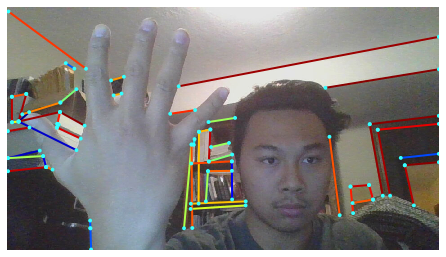

In [126]:
visualize_output(final_out['preds'])

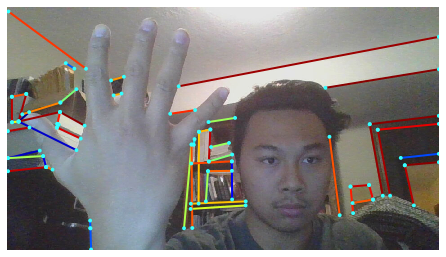

In [127]:
visualize_output(final_out_orig['preds'])

Optimization model vs. Original Pytorch Model appear to act the same!

## Visualizing Environment through Camera

In [51]:
import cv2
from lcnn.models.line_vectorizer_ov2 import LineVectorizer as LV2
from openvino.inference_engine import IENetwork, IECore
import time

def preprocess(im):
    if im.ndim == 2:
        im = np.repeat(im[:, :, None], 3, 2)
    im = im[:, :, :3]
    im_resized = skimage.transform.resize(im, (512, 512)) * 255
    proc_image = (im_resized - M.image.mean) / M.image.stddev
    proc_image = np.rollaxis(proc_image, 2)[None].copy()
    return im, proc_image

def ov_postprocess(obj_res):
    # print([k for k in obj_res.keys()])
    obj_res_dict = {
        'feature': obj_res['1302'],
        'preds': {
            'jmap': obj_res['13701414'],
            'lmap': obj_res['1371'],
            'joff': obj_res['1375']
        }
    }
    
    input_dict2 = {    
        "meta": [
            {
                "junc": torch.zeros(1, 2).to(device),
                "jtyp": torch.zeros(1, dtype=torch.uint8).to(device),
                "Lpos": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                "Lneg": torch.zeros(2, 2, dtype=torch.uint8).to(device),
            }
        ],
        "target": {
            "jmap": torch.zeros([1, 1, 128, 128]).to(device),
            "joff": torch.zeros([1, 1, 2, 128, 128]).to(device),
        },
        "mode": "testing",
    }
    return obj_res_dict, input_dict2

def create_visual(H, im):
    lines = H["lines"][0] / 128 * im.shape[:2]
    scores = H["score"][0]
    for i in range(1, len(lines)):
        if (lines[i] == lines[0]).all():
            lines = lines[:i]
            scores = scores[:i]
            break

    # postprocess lines to remove overlapped lines
    diag = (im.shape[0] ** 2 + im.shape[1] ** 2) ** 0.5
    nlines, nscores = postprocess(lines, scores, diag * 0.01, 0, False)
    drawn_image = im

    for (a, b), s in zip(nlines, nscores):
        if s < 0.99:
            continue

        start_point = (int(a[1]), int(a[0]))
        end_point = (int(b[1]), int(b[0]))
        color = (0, 0, 0) 
        thickness = 3
        drawn_image = cv2.line(drawn_image, start_point, end_point, color, thickness) 
    return drawn_image

def video_capture():
    
    # Setting up OpenVINO
    ie = IECore()
    path_to_xml = './multitask_opt/multitask.xml'
    path_to_objbin = './multitask_opt/multitask.bin'
    # path_to_xml = './hg_opt/hg.xml'
    # path_to_objbin = './hg_opt/hg.bin'
    obj_net = ie.read_network(path_to_xml, path_to_objbin)
    input_layer = next(iter(obj_net.inputs))
    obj_exec_net = ie.load_network(network=obj_net, device_name='CPU', num_requests=1)
    
    path_to_xml = './linevec_fc1_opt/linevec_fc1.xml'
    path_to_objbin = './linevec_fc1_opt/linevec_fc1.bin'
    fc1_net = ie.read_network(path_to_xml, path_to_objbin)
    fc1_exec_net = ie.load_network(network=fc1_net, device_name='CPU', num_requests=1)
    
    path_to_xml = './linevec_fc2_opt/linevec_fc2.xml'
    path_to_objbin = './linevec_fc2_opt/linevec_fc2.bin'
    fc2_net = ie.read_network(path_to_xml, path_to_objbin)
    
    # Setting up line vectorizer
    lv = LV2(fc1_exec_net, fc2_net, ie, device) # fc1, fc2, ie, device
    lv.to(device)
    lv.eval()
    
    # timestamping
    stamps1 = []
    stamps2 = []
    
    vs = cv2.VideoCapture(0)
    print("Click on the window and press q to exit the application.")
    frame = 0
    i = 0
    while True:
        i = i + 1
        ret, vframe = vs.read()
        
        if not ret:
            print('Failed to pick up frame...')
            vs.release()
            cv2.destroyAllWindows()
            break
        
        stamp1 = stamp2 = stamp3 = 0
        start1 = start2 = start3 = 0
        orig_image, proc_image = preprocess(vframe)

        # Starting timer
        start1 = time.time()
        obj_res = obj_exec_net.infer({input_layer: proc_image})
        stamp1 = time.time() - start1 # nanoseconds (10 ^ -9)
        # stamps1.append(stamp1)

        start2 = time.time()
        obj_res_dict, input_dict2 = ov_postprocess(obj_res)
        with torch.no_grad():
             final_out = lv(obj_res_dict, input_dict2)['preds']
        stamp2 = time.time() - start2

        start3 = time.time()
        vframe = create_visual(final_out, orig_image)
        stamp3 = time.time() - start3
        # stamps2.append(stamp2)
        
        stamp = time.time() - start1
        
        # Time stamp
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(vframe, "Time: " + str(stamp), (30, 30), font, 0.8, (255, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(vframe, "Stamp1: " + str(stamp1), (30, 60), font, 0.8, (255, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(vframe, "Stamp2: " + str(stamp2), (30, 90), font, 0.8, (255, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(vframe, "Stamp3: " + str(stamp3), (30, 120), font, 0.8, (255, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(vframe, "FPS: " + str(1/stamp), (30, 150), font, 0.8, (255, 0, 0), 1, cv2.LINE_AA)
        cv2.imshow("Frame", vframe)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
            
    # do a bit of cleanup
    vs.release()
    cv2.destroyAllWindows()
    # print(np.mean(stamps1), np.mean(stamps2))

In [52]:
video_capture()

Click on the window and press q to exit the application.


In [26]:
vs = cv2.VideoCapture(1)
vs.release()
cv2.destroyAllWindows()